В этом файле мы будем обучать три модели: градиентный бустинг, динейную логистическую регрессию и полносвязную нейронную сеть и сравним их. В качестве основной метрики возьменм ROC AUC 

In [15]:
import numpy as np
import catboost as cat

Загружаем ембеддинги и таргеты

In [16]:
import json

with open("train_embeddings.json") as f:
    x = np.array(json.load(f))

with open("train_target.json") as f:
    y = np.array(json.load(f))

KeyboardInterrupt: 

In [5]:
with open("test_embeddings.json") as f:
    x_test = np.array(json.load(f))

with open("test_target.json") as f:
    y_test = np.array(json.load(f))

Делаем one-hot содирование таргета

In [6]:
indexes = {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3,
       'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}

classes = ['Anxiety', 'Bipolar', 'Depression', 'Normal',
       'Personality disorder', 'Stress', 'Suicidal']

In [7]:
def to_matrix(lables):
    res = np.zeros((len(lables), 7))

    for i in range(len(res)):
        res[i][indexes[lables[i]]] = 1

    return res

def to_classes(probas):
    res = [str()] * len(probas)

    for i in range(len(probas)):
        j_max = 0
        v_max = probas[i][0]
        for j in range(1, 7):
            if probas[i][j] > v_max:
                v_max = probas[i][j]
                j_max = j
        res[i] = classes[j_max]
    
    return np.array(res)


y_cat = to_matrix(y)
y_cat_test = to_matrix(y_test)

Функции для оценки качества модели

In [8]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# выводит precision, recall, f1 score и ROC AUC
def print_metrics(pred):

    roc_auc = roc_auc_score(y_cat_test, pred, labels=classes, average="weighted")
    prf1 = precision_recall_fscore_support(y_test, to_classes(pred), labels=classes, average="weighted")
    print(
        f"precision = {prf1[0]}",
        f"recall = {prf1[1]}",
        f"f1 score = {prf1[2]}",
        f"ROC AUC = {roc_auc}",
    sep="\n")

# выводит матрицу ошибок
def print_confusion_matrix(pred):

    ticks = {i: classes[i] for i in range(len(classes))}

    mat_con = confusion_matrix(y_test, pred, labels=classes)

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(mat_con, cmap=plt.cm.YlOrRd, alpha=0.5)

    for i in range(mat_con.shape[0]):
        for j in range(mat_con.shape[1]):
            ax.text(x=j, y=i,s=mat_con[i, j], va='center', ha='center', size='xx-large')

    plt.xticks(range(0,7), classes, fontsize= 8)
    plt.yticks(range(0,7), classes, fontsize= 8)
    plt.xlabel("Predictions", fontsize=16)
    plt.ylabel("Actuals", fontsize=16)
    plt.title("Confusion Matrix", fontsize=15)
    plt.show()
    plt.clf()

Обучаем градиентный бустинг

In [17]:
grad_boost_model = cat.CatBoostClassifier(5, depth=9)

grad_boost_model.fit(x, y,verbose=False, plot=True, eval_set=(x_test, y_test), early_stopping_rounds=20)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучаем линейную логистическую регрессию

In [11]:
from sklearn.linear_model import LogisticRegression

linear_model = LogisticRegression()
linear_model.fit(x, y)

d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Обучаем нейронную сеть

In [12]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
# from tensorflow.keras.layers import BatchNormalization

n = 180

neuro_network_model = Sequential([
    Dense(384, input_shape=(384,), activation="relu"),
    Dropout(0.35),
    Dense(n, input_shape=(384,), activation="relu"),
    Dropout(0.35),
    Dense(7, input_shape=(n,), activation='softmax')
])

neuro_network_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["f1_score"])

neuro_network_model.fit(x, y_cat, batch_size=50, epochs=5)

d:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
840/840 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - f1_score: 0.6371 - loss: 1.0436
Epoch 2/5
840/840 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - f1_score: 0.7740 - loss: 0.6349
Epoch 3/5
840/840 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - f1_score: 0.8187 - loss: 0.5074
Epoch 4/5
840/840 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - f1_score: 0.8422 - loss: 0.4348
Epoch 5/5
840/840 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - f1_score: 0.8646 - loss: 0.3730


Смотрим на метрики моделей

Gradient boosting:
precision = 0.8695368778572613
recall = 0.8635918527222876
f1 score = 0.8633070755006174
ROC AUC = 0.9734300817604523


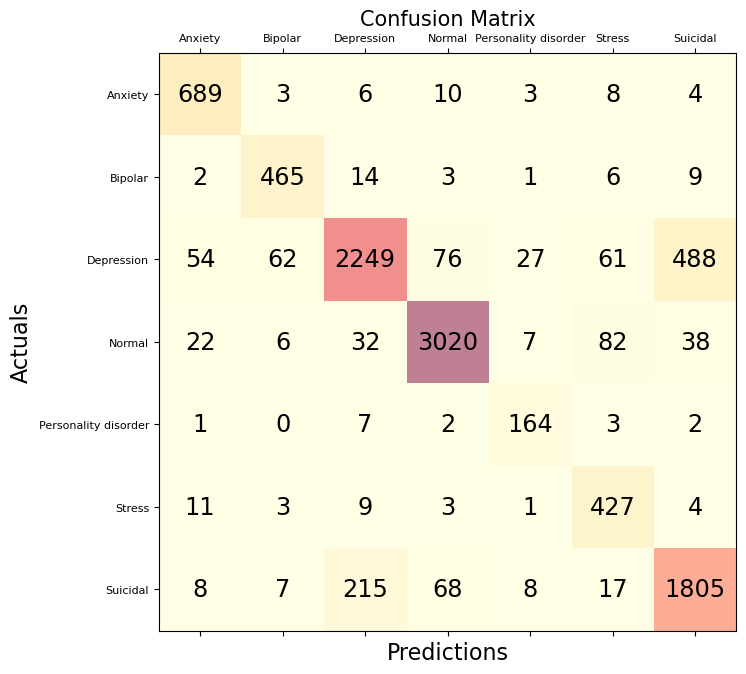


Linear log regress:
precision = 0.7580807272769713
recall = 0.7247356051703878
f1 score = 0.732154289592968
ROC AUC = 0.934301627378347


<Figure size 640x480 with 0 Axes>

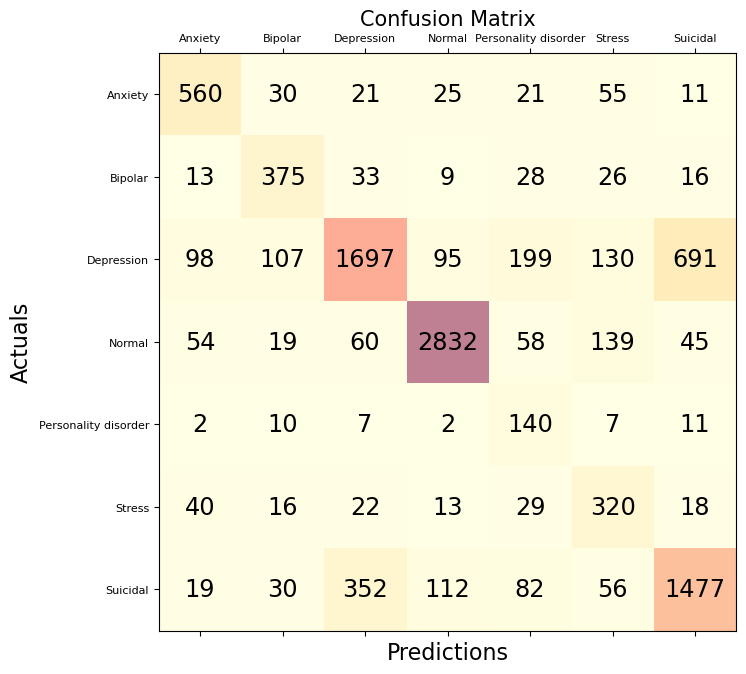


Neuro network:
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
precision = 0.7752165000042851
recall = 0.7545045045045045
f1 score = 0.7564028076316006
ROC AUC = 0.9440217370676178
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Figure size 640x480 with 0 Axes>

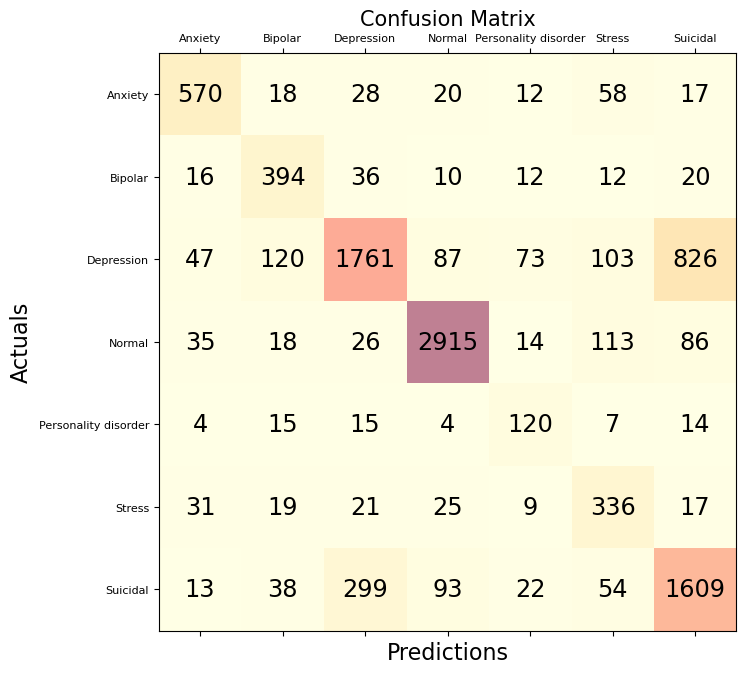

<Figure size 640x480 with 0 Axes>

In [13]:
print("Gradient boosting:")
print_metrics(grad_boost_model.predict_proba(x_test))
print_confusion_matrix(grad_boost_model.predict(x_test))

print("\nLinear log regress:")
print_metrics(linear_model.predict_proba(x_test))
print_confusion_matrix(linear_model.predict(x_test))

print("\nNeuro network:")
print_metrics(neuro_network_model.predict(x_test, verbose=0))
print_confusion_matrix(to_classes(neuro_network_model.predict(x_test, verbose=0)))